In [1]:
import pathlib
import torch
import numpy as np
import matplotlib.pyplot as plt

# Predicting Storm Surge in Venice

### Goal

Predict water level of the next 24h


![stations](MSLP_stations.png)


### Training Data

* Simulated mean sea level pressure (MSLP)
* Measured wind speed and direction
* Measured water level

One FNN example consists of:

1. The simulated MSLP values previous 24h + current MSLP + next 24h sampled every 3h

```
14 stations * (8 + 8 + 1) = 238
```

2. Wind speed and direction at PI station 10h (1 hourly) + current values

```    
2 measurements * (10 + 1) = 22
```

3. Water level (surge only) previous 50h (1 hourly) + current value

```
1 measurement * (50 + 1) = 51
```

Which makes a total of 311 features per example.                                                                                                                                                                                                                                                                                                          

# Datasets

In [2]:
import h5py
from torch.utils.data import Dataset

class HDF5Dataset(Dataset):
    """Read HDF5 files from a directory"""

    def __init__(self, directory):
        self.directory = pathlib.Path(directory)
        self.files = list(self.directory.glob("*.hdf5"))

    def __getitem__(self, index):
        with h5py.File(self.files[index], "r") as src:
            inputs = src["inputs"][:]
            labels = src["labels"][:]
        return inputs, labels

    def __len__(self):
        return len(self.files)

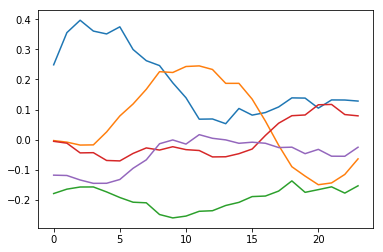

Inputs shape: (311,)
Labels shape: (24,)


In [3]:
dataset = HDF5Dataset('../../exchange/venice/all_data/devel_data/test')
for _ in range(5):
    inputs, labels = dataset[np.random.randint(low=0, high=len(dataset))]
    plt.plot(labels)
plt.show()
print(f"Inputs shape: {inputs.shape}")
print(f"Labels shape: {labels.shape}")

# Dataloaders

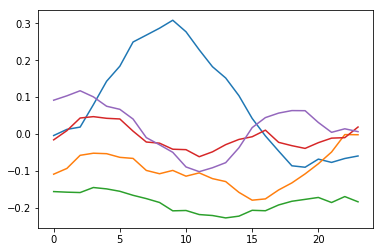

In [4]:
from torch.utils.data import DataLoader

loader = iter(DataLoader(dataset, batch_size=5, shuffle=True))
inputs, labels = next(loader)
for y in labels:
    plt.plot(y.numpy())
plt.show()

# Samplers

In [5]:
from torch.utils.data import Sampler

class ExtremeRandomSampler(Sampler):
    """Sample a random extreme event with a given probability"""

    def __init__(self, dataset, num_samples, extreme_height=0.4, extreme_probability=0.5):
        self.dataset = dataset
        self.num_samples = num_samples
        self.extreme_height = extreme_height
        self.extreme_probability = extreme_probability
        self.prob = [extreme_probability, 1 - extreme_probability]
        self.length = len(dataset)

    def __iter__(self):
        indices = []
        for _ in range(self.num_samples):
            extreme = np.random.choice([False, True], p=self.prob)
            idx = np.random.randint(low=0, high=self.length)

            while not extreme:
                _, labels = self.dataset[idx]
                if np.any(labels > self.extreme_height):
                    extreme = True
                else:
                    idx = np.random.randint(low=0, high=self.length)
            indices.append(idx)
        return iter(indices)

    def __len__(self):
        return self.length

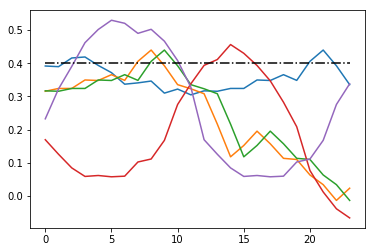

In [6]:
from torch.utils.data import DataLoader, RandomSampler

sampler = ExtremeRandomSampler(dataset, num_samples=5, extreme_probability=1., extreme_height=0.4)
loader = iter(DataLoader(dataset, batch_size=5, sampler=sampler))
inputs, labels = next(loader)
for y in labels:
    plt.plot(y.numpy())

length = y.size(0)
plt.plot(np.arange(length), np.zeros(length)+0.4, '-.', color='black')
plt.show()

# Neural Networks

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class FNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        # you could write ifs / loops here !
        return x

In [8]:
BATCH_SIZE = 1000
INPUT_SIZE = 311
OUTPUT_SIZE = 24
HIDDEN_SIZE = 1024

LEARNING_RATE = 0.001
N_EPOCHS = 2

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_ds = HDF5Dataset('../../exchange/venice/all_data/devel_data/test')
val_ds = HDF5Dataset('../../exchange/venice/all_data/devel_data/test')

# with or without sampler
sampler = ExtremeRandomSampler(dataset, num_samples=len(dataset), extreme_height=0.4, extreme_probability=0.01)

train_dl = DataLoader(
    train_ds, batch_size=BATCH_SIZE,
    shuffle=True
    # sampler=sampler
)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

model = FNN(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

### Train Loop - Manually

A higher level tool for training loops is for example [ignite](https://pytorch.org/ignite)

In [10]:
for epoch in range(N_EPOCHS):
    print(f"Epoch {epoch+1}/{N_EPOCHS}")
    
    # Train
    model.train()  # IMPORTANT
    
    running_loss, correct = 0.0, 0
    for X, y in train_dl:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        # with torch.set_grad_enabled(True):
        y_ = model(X)
        loss = criterion(y_, y)

        loss.backward()
        optimizer.step()

        # Statistics
        print(f"    batch loss: {loss.item():0.3f}")
        running_loss += loss.item() * X.shape[0]

    print(f"  Train Loss: {running_loss / len(train_dl.dataset)}")


    # Eval
    model.eval()  # IMPORTANT

    running_loss, correct = 0.0, 0
    with torch.no_grad():  # IMPORTANT
        for X, y in val_dl:
            X, y = X.to(device), y.to(device)

            y_ = model(X)

            loss = criterion(y_, y)
            running_loss += loss.item() * X.shape[0]

    print(f"  Valid Loss: {running_loss / len(val_dl.dataset)}")
    print()

Epoch 1/2
    batch loss: 0.038
    batch loss: 0.063
    batch loss: 0.028
    batch loss: 0.020
    batch loss: 0.021
    batch loss: 0.022
    batch loss: 0.020
    batch loss: 0.017
    batch loss: 0.009
  Train Loss: 0.02863104083754907
  Valid Loss: 0.011488944470741698

Epoch 2/2
    batch loss: 0.012
    batch loss: 0.012
    batch loss: 0.013
    batch loss: 0.012
    batch loss: 0.011
    batch loss: 0.010
    batch loss: 0.009
    batch loss: 0.008
    batch loss: 0.009
  Train Loss: 0.010827879108503372
  Valid Loss: 0.008876365201203357



## Results!

![performance](https://raw.githubusercontent.com/DHI/venice-predict/master/images/performance.png?token=AcLu2dIwONN3tLNTNcn3iB5JcnY4McW1ks5cStxewA%3D%3D)

In [ ]:
import pathlib
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Sampler, Dataset, DataLoader
import h5py

class HDF5Dataset(Dataset):
    """Read HDF5 files from a directory"""

    def __init__(self, directory):
        self.directory = pathlib.Path(directory)
        self.files = list(self.directory.glob("*.hdf5"))

    def __getitem__(self, index):
        with h5py.File(self.files[index], "r") as src:
            inputs = src["inputs"][:]
            labels = src["labels"][:]
        return inputs, labels

    def __len__(self):
        return len(self.files)

class ExtremeRandomSampler(Sampler):
    """Sample a random extreme event with a given probability"""

    def __init__(self, dataset, num_samples, extreme_height=0.4, extreme_probability=0.5):
        self.dataset = dataset
        self.num_samples = num_samples
        self.extreme_height = extreme_height
        self.extreme_probability = extreme_probability
        self.prob = [extreme_probability, 1 - extreme_probability]
        self.length = len(dataset)

    def __iter__(self):
        indices = []
        for _ in range(self.num_samples):
            extreme = np.random.choice([False, True], p=self.prob)
            idx = np.random.randint(low=0, high=self.length)

            while not extreme:
                _, labels = self.dataset[idx]
                if np.any(labels > self.extreme_height):
                    extreme = True
                else:
                    idx = np.random.randint(low=0, high=self.length)
            indices.append(idx)
        return iter(indices)

    def __len__(self):
        return self.length

class FNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        # you could write ifs / loops here !
        return x


BATCH_SIZE = 100
INPUT_SIZE = 311
OUTPUT_SIZE = 24
HIDDEN_SIZE = 1024

LEARNING_RATE = 0.001
N_EPOCHS = 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_ds = HDF5Dataset('../../exchange/venice/all_data/devel_data/test')
val_ds = HDF5Dataset('../../exchange/venice/all_data/devel_data/test')

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

model = FNN(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

for epoch in range(N_EPOCHS):
    print(f"Epoch {epoch+1}/{N_EPOCHS}")
    
    # Train
    model.train()  # IMPORTANT
    
    running_loss, correct = 0.0, 0
    for X, y in train_dl:
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        # with torch.set_grad_enabled(True):
        y_ = model(X)
        loss = criterion(y_, y)

        loss.backward()
        optimizer.step()
        
        # Statistics
        print(f"    batch loss: {loss.item():0.3f}")
        running_loss += loss.item() * X.shape[0]
    
    print(f"  Train Loss: {running_loss / len(train_dl.dataset)}")
    
    
    # Eval
    model.eval()  # IMPORTANT
    
    running_loss, correct = 0.0, 0
    with torch.no_grad():  # IMPORTANT
        for X, y in val_dl:
            X, y = X.to(device), y.to(device)
                    
            y_ = model(X)
            
            loss = criterion(y_, y)
            running_loss += loss.item() * X.shape[0]
    
    print(f"  Valid Loss: {running_loss / len(val_dl.dataset)}")
    print()

# Thank you!

Some further links:

* Talk by [Stefan Sotte](https://github.com/sotte/pytorch_tutorial)
* Transfer Learning [Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
* Use all of Tensorboards visualization features via [tensorboardX](https://github.com/lanpa/tensorboardX)!
* [torchvision](https://pytorch.org/docs/stable/torchvision/index.html) for transforms, pre-trained models, etc...